In [11]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
import numpy as np
from sklearn.model_selection import train_test_split

import librosa 
from librosa import feature
import soundfile
import os, glob, pickle
import re #split strings

from sklearn import preprocessing

fn_list_i = [
 feature.chroma_stft,
 feature.spectral_centroid,
 feature.spectral_bandwidth,
 feature.spectral_rolloff
]
 
fn_list_ii = [
 feature.zero_crossing_rate
]
#feature.rmse,

emotions={ #german language
    'W':'anger',
    'L':'boredom',
    'E':'disgust',
    'A':'anxiety/fear',# *1
    'F':'happiness',# *0
    'T':'sadness',# *1
    'N':'neutral',# *0
}

# Not stressed: happy(2), calm(1).
# Stressed:     sad(3), fearful(5)
stress_emotions = {
    'F':0,
    'N':0,
    'A':1,
    'T':1
}
selected_emotions = {'F','N','A','T'}

In [12]:
#preprocesamiento de corpus
def preprocessing_data(filename):
    # 1) audio: mono 
    # 2) frecuencia de muestreo(SR): 16000Hz
    data, sr = librosa.load(filename, sr=16000, mono=True)
    #3) normalizacion
    X_scale = preprocessing.normalize([data])[0]
    #plot_data(normalizado, sr)
    #TODO: otros: farming, windowing, Voice Activity Detector (VAD), noise reduction,
    return [X_scale, sr]

In [13]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X_file_data = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X_file_data))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))#concatena ([1,2][3,4]) => [1,2,3,4]
            
            mfccs_var = np.var(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs_var)) 
            
            mfccs_std = np.std(librosa.feature.mfcc(y=X_file_data, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs_std)) 
    
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X_file_data, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X_file_data), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [14]:

def load_data(test_size=0.2):
    x,y=[],[]
    #for file in glob.glob("/media/y/730D-8298/DATASETS/ravdess_test/Actor_*/*.wav"): #* PC
    for file in glob.glob("/media/y/730D-8298/DATASETS/Emo-DB/wav/*.wav"): #* PC
        file_name = os.path.basename(file) #            03-01-01-01-01-01-01.wav
        print('File:  %s' % (file_name), end='\r')
        file_name_no_type = file_name.split(".")[0] #   03-01-01-01-01-01-01
        #list_emotions = file_name_no_type.split("-") #  ['03', '01', '01', '01', '01', '01', '01']
        emotion = file_name_no_type[5]
        
        if emotion in selected_emotions:
            e = stress_emotions[emotion]
           
            #signal, sample_rate = preprocessing_data(file)
            feature = extract_feature(file, chroma=True, mfcc=True, mel=True, contrast=True, tonnetz=True) #get_feature_vector(signal, sample_rate)#extract_feature(file, mfcc=True) #TODO: add more features
            x.append(feature)
            y.append(e)

    return np.array(x), np.array(y)

In [16]:
X_data,Y_data = load_data()
print("\n")
print("X_data:", X_data.shape, "Y_data:",  Y_data.shape)

File:  08a01Fd.wav

X_data: (281, 273) Y_data: (281,)


### Normalización de datos

In [17]:
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X_data)
Y = Y_data 
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (281, 273) Y_data: (281,)


### Reducción de dimensionalidad con PCA

In [18]:
from sklearn.decomposition import PCA
X =  PCA(n_components=150).fit_transform(X)
print("X_data:", X.shape, "Y_data:",  Y.shape)

X_data: (281, 150) Y_data: (281,)


No estresados: 150 | Estresados: 131


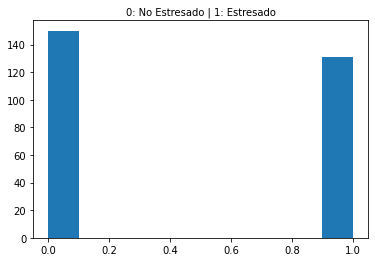

In [19]:
estresados = Y.sum()
no_estresados = Y.shape[0]-estresados
print("No estresados:",no_estresados, "| Estresados:", estresados)


import matplotlib.pyplot as plt

data = Y
plt.hist(data)
plt.title('0: No Estresado | 1: Estresado', fontsize=10)
#plt.savefig("Estres_NoEstres.png")
plt.show()

### división de datos: Entrenamiento, validación y prueba

In [20]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X,Y, test_size=0.3, random_state=29) # *random_state para elegir siempre los mismo datos
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test,Y_val_test, test_size=0.5, random_state=40) #TODO: eliminar random_state para pruebas finales 
print("Entrenamiento:", X_train.shape, Y_train.shape, "Validación:", X_val.shape, Y_val.shape, "Prueba:", X_test.shape, Y_test.shape)

Entrenamiento: (196, 150) (196,) Validación: (42, 150) (42,) Prueba: (43, 150) (43,)


In [21]:
model = Sequential([ 
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)), 
    Dense(64, activation="relu"), 
    Dense(1, activation="sigmoid")
])
#optimizador
model.compile(optimizer = "sgd", loss="binary_crossentropy", metrics=["accuracy"]) #metrics=["accuracy"]

In [22]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=450, verbose=2, validation_data=(X_val, Y_val))

Epoch 1/450
7/7 - 0s - loss: 0.6729 - accuracy: 0.6888 - val_loss: 0.6787 - val_accuracy: 0.6429
Epoch 2/450
7/7 - 0s - loss: 0.6674 - accuracy: 0.7143 - val_loss: 0.6754 - val_accuracy: 0.6429
Epoch 3/450
7/7 - 0s - loss: 0.6624 - accuracy: 0.7398 - val_loss: 0.6700 - val_accuracy: 0.7143
Epoch 4/450
7/7 - 0s - loss: 0.6553 - accuracy: 0.7806 - val_loss: 0.6653 - val_accuracy: 0.7381
Epoch 5/450
7/7 - 0s - loss: 0.6500 - accuracy: 0.7857 - val_loss: 0.6591 - val_accuracy: 0.7619
Epoch 6/450
7/7 - 0s - loss: 0.6435 - accuracy: 0.7857 - val_loss: 0.6541 - val_accuracy: 0.7619
Epoch 7/450
7/7 - 0s - loss: 0.6383 - accuracy: 0.8010 - val_loss: 0.6499 - val_accuracy: 0.8095
Epoch 8/450
7/7 - 0s - loss: 0.6332 - accuracy: 0.8061 - val_loss: 0.6456 - val_accuracy: 0.7857
Epoch 9/450
7/7 - 0s - loss: 0.6275 - accuracy: 0.7908 - val_loss: 0.6413 - val_accuracy: 0.7857
Epoch 10/450
7/7 - 0s - loss: 0.6223 - accuracy: 0.7959 - val_loss: 0.6361 - val_accuracy: 0.7857
Epoch 11/450
7/7 - 0s - loss:

Epoch 85/450
7/7 - 0s - loss: 0.3183 - accuracy: 0.8980 - val_loss: 0.3348 - val_accuracy: 0.9524
Epoch 86/450
7/7 - 0s - loss: 0.3152 - accuracy: 0.8980 - val_loss: 0.3343 - val_accuracy: 0.9524
Epoch 87/450
7/7 - 0s - loss: 0.3123 - accuracy: 0.9082 - val_loss: 0.3301 - val_accuracy: 0.9524
Epoch 88/450
7/7 - 0s - loss: 0.3092 - accuracy: 0.9133 - val_loss: 0.3269 - val_accuracy: 0.9524
Epoch 89/450
7/7 - 0s - loss: 0.3064 - accuracy: 0.9082 - val_loss: 0.3220 - val_accuracy: 0.9762
Epoch 90/450
7/7 - 0s - loss: 0.3032 - accuracy: 0.9133 - val_loss: 0.3182 - val_accuracy: 0.9762
Epoch 91/450
7/7 - 0s - loss: 0.3003 - accuracy: 0.9184 - val_loss: 0.3153 - val_accuracy: 0.9762
Epoch 92/450
7/7 - 0s - loss: 0.2976 - accuracy: 0.9184 - val_loss: 0.3133 - val_accuracy: 0.9762
Epoch 93/450
7/7 - 0s - loss: 0.2943 - accuracy: 0.9184 - val_loss: 0.3104 - val_accuracy: 0.9762
Epoch 94/450
7/7 - 0s - loss: 0.2913 - accuracy: 0.9235 - val_loss: 0.3033 - val_accuracy: 0.9762
Epoch 95/450
7/7 - 0

Epoch 168/450
7/7 - 0s - loss: 0.1397 - accuracy: 0.9847 - val_loss: 0.1600 - val_accuracy: 0.9762
Epoch 169/450
7/7 - 0s - loss: 0.1384 - accuracy: 0.9796 - val_loss: 0.1587 - val_accuracy: 0.9762
Epoch 170/450
7/7 - 0s - loss: 0.1370 - accuracy: 0.9847 - val_loss: 0.1590 - val_accuracy: 0.9762
Epoch 171/450
7/7 - 0s - loss: 0.1355 - accuracy: 0.9847 - val_loss: 0.1584 - val_accuracy: 0.9762
Epoch 172/450
7/7 - 0s - loss: 0.1341 - accuracy: 0.9847 - val_loss: 0.1597 - val_accuracy: 0.9524
Epoch 173/450
7/7 - 0s - loss: 0.1327 - accuracy: 0.9847 - val_loss: 0.1598 - val_accuracy: 0.9524
Epoch 174/450
7/7 - 0s - loss: 0.1314 - accuracy: 0.9847 - val_loss: 0.1581 - val_accuracy: 0.9524
Epoch 175/450
7/7 - 0s - loss: 0.1301 - accuracy: 0.9847 - val_loss: 0.1577 - val_accuracy: 0.9524
Epoch 176/450
7/7 - 0s - loss: 0.1287 - accuracy: 0.9898 - val_loss: 0.1561 - val_accuracy: 0.9524
Epoch 177/450
7/7 - 0s - loss: 0.1276 - accuracy: 0.9847 - val_loss: 0.1571 - val_accuracy: 0.9524
Epoch 178/

Epoch 251/450
7/7 - 0s - loss: 0.0656 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy: 0.9762
Epoch 252/450
7/7 - 0s - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.1153 - val_accuracy: 0.9762
Epoch 253/450
7/7 - 0s - loss: 0.0645 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 0.9762
Epoch 254/450
7/7 - 0s - loss: 0.0639 - accuracy: 1.0000 - val_loss: 0.1161 - val_accuracy: 0.9524
Epoch 255/450
7/7 - 0s - loss: 0.0636 - accuracy: 1.0000 - val_loss: 0.1149 - val_accuracy: 0.9762
Epoch 256/450
7/7 - 0s - loss: 0.0629 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9524
Epoch 257/450
7/7 - 0s - loss: 0.0625 - accuracy: 1.0000 - val_loss: 0.1152 - val_accuracy: 0.9524
Epoch 258/450
7/7 - 0s - loss: 0.0620 - accuracy: 1.0000 - val_loss: 0.1145 - val_accuracy: 0.9524
Epoch 259/450
7/7 - 0s - loss: 0.0615 - accuracy: 1.0000 - val_loss: 0.1131 - val_accuracy: 0.9762
Epoch 260/450
7/7 - 0s - loss: 0.0608 - accuracy: 1.0000 - val_loss: 0.1132 - val_accuracy: 0.9524
Epoch 261/

Epoch 334/450
7/7 - 0s - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.0985 - val_accuracy: 0.9762
Epoch 335/450
7/7 - 0s - loss: 0.0355 - accuracy: 1.0000 - val_loss: 0.0984 - val_accuracy: 0.9762
Epoch 336/450
7/7 - 0s - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9762
Epoch 337/450
7/7 - 0s - loss: 0.0351 - accuracy: 1.0000 - val_loss: 0.0982 - val_accuracy: 0.9762
Epoch 338/450
7/7 - 0s - loss: 0.0349 - accuracy: 1.0000 - val_loss: 0.0981 - val_accuracy: 0.9762
Epoch 339/450
7/7 - 0s - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.0979 - val_accuracy: 0.9762
Epoch 340/450
7/7 - 0s - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.0979 - val_accuracy: 0.9762
Epoch 341/450
7/7 - 0s - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.0977 - val_accuracy: 0.9762
Epoch 342/450
7/7 - 0s - loss: 0.0340 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 0.9762
Epoch 343/450
7/7 - 0s - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.0977 - val_accuracy: 0.9524
Epoch 344/

Epoch 417/450
7/7 - 0s - loss: 0.0225 - accuracy: 1.0000 - val_loss: 0.0921 - val_accuracy: 0.9762
Epoch 418/450
7/7 - 0s - loss: 0.0224 - accuracy: 1.0000 - val_loss: 0.0919 - val_accuracy: 0.9762
Epoch 419/450
7/7 - 0s - loss: 0.0223 - accuracy: 1.0000 - val_loss: 0.0918 - val_accuracy: 0.9762
Epoch 420/450
7/7 - 0s - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.0918 - val_accuracy: 0.9762
Epoch 421/450
7/7 - 0s - loss: 0.0221 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9762
Epoch 422/450
7/7 - 0s - loss: 0.0220 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9762
Epoch 423/450
7/7 - 0s - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.0917 - val_accuracy: 0.9762
Epoch 424/450
7/7 - 0s - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9762
Epoch 425/450
7/7 - 0s - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9762
Epoch 426/450
7/7 - 0s - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9762
Epoch 427/

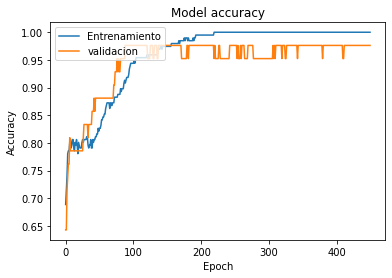

In [23]:
#plot precisión
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'validacion'], loc='upper left')
plt.show()

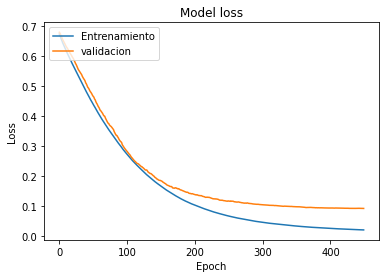

In [24]:
#plot perdida
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Entrenamiento', 'validacion'], loc='upper left') 
plt.show()

### Exactitud

In [13]:
print(model.evaluate(X_test,Y_test)[1]*100,"%") #[0] perdida, [1] presicion

2/2 [==============================] - 0s 4ms/step - loss: 0.2145 - accuracy: 0.9070
90.69767594337463 %
